<a href="https://colab.research.google.com/github/ayulockin/SwAV-TF/blob/master/Fine_Tuning_on_Flower_Full_Dataset_Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Aug 17 06:18:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras import models

import matplotlib.pyplot as plt 
import numpy as np
import random
import time
import os

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

## Dataset gathering and preparation

In [4]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

@tf.function
def scale_resize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224)) # Resizing to highest resolution used while training swav
    return (image, label)

training_ds = (
    train_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testing_ds = (
    validation_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## ResNet50 base and a custom classification head

In [5]:
def get_training_model(trainable=False):
    inputs = layers.Input(shape=(224, 224, 3))
    EXTRACTOR = tf.keras.applications.ResNet50(weights="imagenet", include_top=False,
        input_shape=(224, 224, 3))
    EXTRACTOR.trainable = trainable
    x = EXTRACTOR(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(5, activation="softmax")(x)
    classifier = models.Model(inputs=inputs, outputs=x)
    
    return classifier

In [6]:
model = get_training_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


## Callback

In [7]:
# Early Stopping to prevent overfitting
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

## Metric Visualization

In [8]:
def plot_training_loss(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.title("Loss")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss")
		plt.legend(loc="upper right")
		plt.show()

def plot_training_accuracy(H):
	with plt.xkcd():
		plt.plot(H.history["acc"], label="train_acc")
		plt.plot(H.history["val_acc"], label="val_acc")
		plt.title("Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Accuracy")
		plt.legend(loc="lower right")
		plt.show()

## Without Augmentation

### Warm Up

In [9]:
model = get_training_model()

model.compile(loss="sparse_categorical_crossentropy", metrics=["acc"],
                     optimizer='adam')

history = model.fit(training_ds,
                 validation_data=testing_ds,
                 epochs=35,
                 callbacks=[early_stopper])

Epoch 1/35
49/49 [==============================] - 11s 234ms/step - loss: 1.5814 - acc: 0.2885 - val_loss: 1.5539 - val_acc: 0.3109
Epoch 2/35
49/49 [==============================] - 10s 202ms/step - loss: 1.5063 - acc: 0.3599 - val_loss: 1.5196 - val_acc: 0.3364
Epoch 3/35
49/49 [==============================] - 10s 202ms/step - loss: 1.4792 - acc: 0.3849 - val_loss: 1.5015 - val_acc: 0.3527
Epoch 4/35
49/49 [==============================] - 10s 206ms/step - loss: 1.4616 - acc: 0.3962 - val_loss: 1.4877 - val_acc: 0.3655
Epoch 5/35
49/49 [==============================] - 10s 206ms/step - loss: 1.4480 - acc: 0.4058 - val_loss: 1.4758 - val_acc: 0.3764
Epoch 6/35
49/49 [==============================] - 10s 204ms/step - loss: 1.4365 - acc: 0.4141 - val_loss: 1.4651 - val_acc: 0.3782
Epoch 7/35
49/49 [==============================] - 10s 205ms/step - loss: 1.4263 - acc: 0.4215 - val_loss: 1.4552 - val_acc: 0.3891
Epoch 8/35
49/49 [==============================] - 10s 206ms/step - 

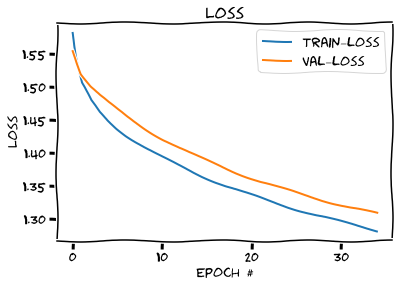

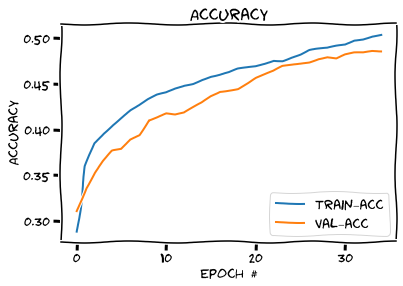

In [10]:
plot_training_loss(history)
plot_training_accuracy(history)

In [11]:
model.save('warmup.h5')

### Fine tune CNN

In [12]:
model.layers[1].trainable = True

model.compile(loss="sparse_categorical_crossentropy", metrics=["acc"],
                     optimizer=tf.keras.optimizers.Adam(1e-5))

history = model.fit(training_ds,
                 validation_data=testing_ds,
                 epochs=35,
                 callbacks=[early_stopper])

Epoch 1/35
49/49 [==============================] - 32s 655ms/step - loss: 1.6735 - acc: 0.3160 - val_loss: 1.4681 - val_acc: 0.3727
Epoch 2/35
49/49 [==============================] - 31s 630ms/step - loss: 1.3830 - acc: 0.4253 - val_loss: 1.3472 - val_acc: 0.4727
Epoch 3/35
49/49 [==============================] - 31s 638ms/step - loss: 1.2870 - acc: 0.4817 - val_loss: 1.2152 - val_acc: 0.5109
Epoch 4/35
49/49 [==============================] - 31s 641ms/step - loss: 1.2273 - acc: 0.5147 - val_loss: 1.2002 - val_acc: 0.5091
Epoch 5/35
49/49 [==============================] - 32s 646ms/step - loss: 1.1049 - acc: 0.5718 - val_loss: 1.0923 - val_acc: 0.6018
Epoch 6/35
49/49 [==============================] - 32s 649ms/step - loss: 1.0075 - acc: 0.6154 - val_loss: 1.0297 - val_acc: 0.6382
Epoch 7/35
49/49 [==============================] - 32s 652ms/step - loss: 0.9441 - acc: 0.6449 - val_loss: 0.9905 - val_acc: 0.6436
Epoch 8/35
49/49 [==============================] - 32s 654ms/step - 

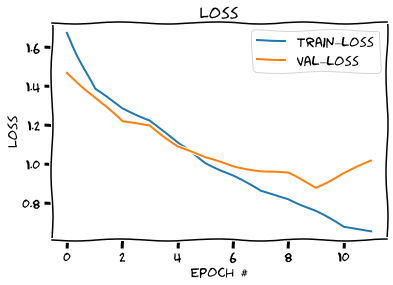

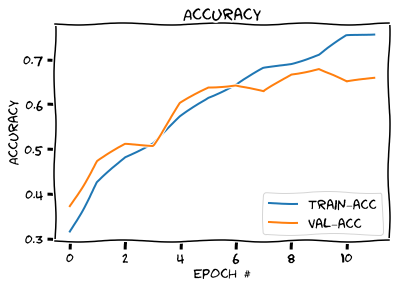

In [13]:
plot_training_loss(history)
plot_training_accuracy(history)

# Training with Augmentation


### Augmentation

In [14]:
# Configs
CROP_SIZE = 224
MIN_SCALE = 0.5
MAX_SCALE = 1.

# Experimental options
options = tf.data.Options()
options.experimental_optimization.noop_elimination = True
options.experimental_optimization.map_vectorization.enabled = True
options.experimental_optimization.apply_default_optimizations = True
options.experimental_deterministic = False
options.experimental_threading.max_intra_op_parallelism = 1

In [15]:
@tf.function
def scale_image(image, label):
	image = tf.image.convert_image_dtype(image, tf.float32)
	return (image, label)

@tf.function
def random_apply(func, x, p):
	return tf.cond(
		tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
				tf.cast(p, tf.float32)),
		lambda: func(x),
		lambda: x)
 
@tf.function
def random_resize_crop(image, label):
  # Conditional resizing
  image = tf.image.resize(image, (260, 260))
  # Get the crop size for given min and max scale
  size = tf.random.uniform(shape=(1,), minval=MIN_SCALE*260,
		          maxval=MAX_SCALE*260, dtype=tf.float32)
  size = tf.cast(size, tf.int32)[0]
  # Get the crop from the image
  crop = tf.image.random_crop(image, (size,size,3))
  crop_resize = tf.image.resize(crop, (CROP_SIZE, CROP_SIZE))
  
  return crop_resize, label

@tf.function
def tie_together(image, label):
  # Scale the pixel values
  image, label = scale_image(image , label)
  # random horizontal flip
  image = random_apply(tf.image.random_flip_left_right, image, p=0.5)
  # Random resized crops
  image, label = random_resize_crop(image, label)
  
  return image, label

In [16]:
trainloader = (
	train_ds
	.shuffle(1024)
	.map(tie_together, num_parallel_calls=AUTO)
	.batch(BATCH_SIZE)
	.prefetch(AUTO)
)

trainloader = trainloader.with_options(options)

### Warmup

In [17]:
model = get_training_model()

model.compile(loss="sparse_categorical_crossentropy", metrics=["acc"],
                     optimizer='adam')

history = model.fit(trainloader,
                 validation_data=testing_ds,
                 epochs=35,
                 callbacks=[early_stopper])

Epoch 1/35
49/49 [==============================] - 11s 219ms/step - loss: 1.6115 - acc: 0.2362 - val_loss: 1.5512 - val_acc: 0.3127
Epoch 2/35
49/49 [==============================] - 10s 206ms/step - loss: 1.5486 - acc: 0.3442 - val_loss: 1.5350 - val_acc: 0.3273
Epoch 3/35
49/49 [==============================] - 10s 207ms/step - loss: 1.5235 - acc: 0.3622 - val_loss: 1.5300 - val_acc: 0.3291
Epoch 4/35
49/49 [==============================] - 10s 207ms/step - loss: 1.5207 - acc: 0.3436 - val_loss: 1.4894 - val_acc: 0.3764
Epoch 5/35
49/49 [==============================] - 10s 205ms/step - loss: 1.4956 - acc: 0.3670 - val_loss: 1.4911 - val_acc: 0.3855
Epoch 6/35
49/49 [==============================] - 10s 209ms/step - loss: 1.4924 - acc: 0.3660 - val_loss: 1.4869 - val_acc: 0.3582
Epoch 7/35
49/49 [==============================] - 10s 208ms/step - loss: 1.4795 - acc: 0.3843 - val_loss: 1.4834 - val_acc: 0.3618
Epoch 8/35
49/49 [==============================] - 10s 209ms/step - 

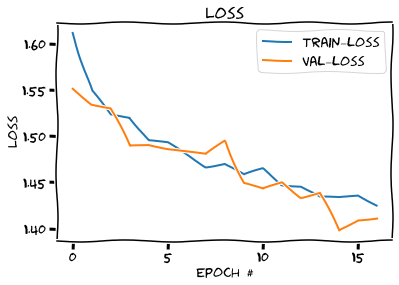

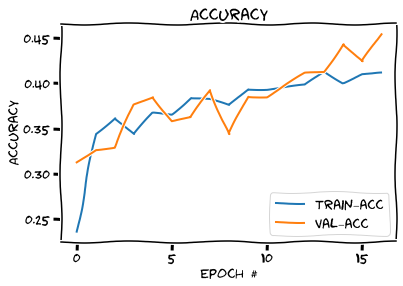

In [18]:
plot_training_loss(history)
plot_training_accuracy(history)

In [19]:
model.save('warmup_augmentation.h5')

### Fine tune CNN

In [20]:
model.layers[1].trainable = True

model.compile(loss="sparse_categorical_crossentropy", metrics=["acc"],
                     optimizer=tf.keras.optimizers.Adam(1e-5))

history = model.fit(trainloader,
                 validation_data=testing_ds,
                 epochs=35,
                 callbacks=[early_stopper])

Epoch 1/35
49/49 [==============================] - 31s 632ms/step - loss: 1.6391 - acc: 0.2901 - val_loss: 1.5306 - val_acc: 0.3709
Epoch 2/35
49/49 [==============================] - 31s 628ms/step - loss: 1.4974 - acc: 0.3692 - val_loss: 1.4744 - val_acc: 0.4036
Epoch 3/35
49/49 [==============================] - 31s 634ms/step - loss: 1.4362 - acc: 0.4000 - val_loss: 1.3899 - val_acc: 0.4491
Epoch 4/35
49/49 [==============================] - 31s 639ms/step - loss: 1.4127 - acc: 0.4147 - val_loss: 1.3342 - val_acc: 0.4491
Epoch 5/35
49/49 [==============================] - 31s 640ms/step - loss: 1.3722 - acc: 0.4340 - val_loss: 1.2904 - val_acc: 0.4545
Epoch 6/35
49/49 [==============================] - 31s 642ms/step - loss: 1.2999 - acc: 0.4683 - val_loss: 1.2447 - val_acc: 0.5109
Epoch 7/35
49/49 [==============================] - 31s 641ms/step - loss: 1.3326 - acc: 0.4535 - val_loss: 1.2879 - val_acc: 0.4745
Epoch 8/35
49/49 [==============================] - 32s 650ms/step - 

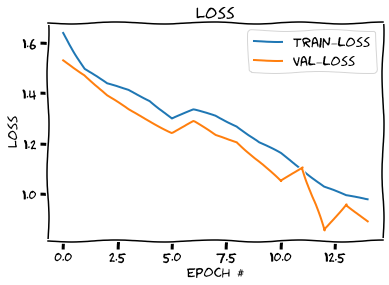

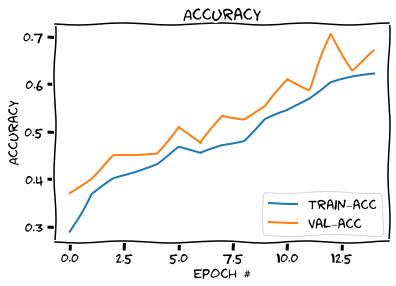

In [21]:
plot_training_loss(history)
plot_training_accuracy(history)

In [22]:
model.save('finetune_augmentation.h5')